In [1]:
## Python packages 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns; sns.set()



In [2]:
# combine csv files - requests from 2014, 2015 and 2016

df_2014= pd.DataFrame.from_csv('foia2014.csv')
df_2015 = pd.DataFrame.from_csv('foia2015.csv')
df_2016= pd.DataFrame.from_csv('foia2016.csv')
df=pd.concat([df_2014, df_2015, df_2016])


In [3]:
# Keep only the closed cases
df_closed = df[df.request_status == 'Closed']

# Keep only granted and denied cases
df_gr_de = df_closed[ (df_closed['final_disposition']=='Granted in full') | (df_closed['final_disposition']=='Denied in full')]

# Keep only the requests from news media category
df_news = df_gr_de[ (df_gr_de['requester_category']=='News Media')]

# Remove any request with description or name as b6
df_b6_removed = df_news[(df_news.request_description != 'b6') & (df_news.requester_name != 'b6')]

# Create a binary column named actual for granted=1 and denied=0
cleandata=df_b6_removed.copy()
cleandata['actual']=0
cleandata.loc[(cleandata['final_disposition']=='Granted in full'),'actual']=1

# convert requested date to datetime and make separate month and year columns
cleandata.loc[:,'req_date']=pd.to_datetime(cleandata['requested_date'])
cleandata.loc[:,'req_month'] = cleandata['req_date'].dt.month
cleandata.loc[:,'req_year'] = cleandata['req_date'].dt.year

In [4]:
# In the request description, keep the words with alphabetic chars only

corpusall = cleandata['request_description'].values # np array of descriptions
flag=[]  
for i in range(len(corpusall)):
    x = corpusall[i].split(' ')
    y= [ word for word in x if word.isalpha()] # for each description, keeps only the words with alpha chars
    
    # flags if at least one word is only alpha chars. flag is a boolean list.
    if y: 
        flag.append(True)
    else: 
        flag.append(False)
        
# clean data with only alphabetic char request description 
cdata=cleandata[flag]


In [5]:
# split the data into training and test data 
train, test = train_test_split(cdata, train_size=0.75, test_size=0.25, random_state=0)


In [6]:
# for the training set, make a list of the descriptions with only alphabetical words
corpus = train['request_description'].values
description_list=[]
for line in corpus:
    x = line.split(' ')
    y= [ word for word in x if word.isalpha()]
    if y:
        description = ' '.join(y)
        description_list.append(description)

In [7]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

# define stop words
my_additional_stop_words=[] # could define corpus specific stop words
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words) # all the stop words

#tfidf vectorizer, tokenize, use the stop words, 1-grams and 2-grams
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=stop_words, ngram_range=(1,2))

# sparse matrix with the scores of the words for each request
tfidf_result = vectorizer.fit_transform(description_list)

# clean up feature names
features= [word.encode('ascii', 'ignore') for word in vectorizer.get_feature_names()]

# np array with the scores of the words for each request
tfidf_arr =np.asarray(tfidf_result.toarray())

# scores np array for each n-gram 
scores = tfidf_arr.sum(axis=0)

# np array indicator matrix
req_desc_ind_train=tfidf_arr.copy()
req_desc_ind_train[req_desc_ind_train>0]=1

In [8]:
# sort the scores  
sorted_scores = sorted(scores, reverse=True)
sorted_indices= [b[0] for b in sorted(enumerate(scores),key=lambda i:i[1], reverse=True)]

In [9]:
# pick the highest scored 300 features with their indices
numfeatures = 300

bestfeatures=[]
bestindices=[]
for i in sorted_indices[:numfeatures]:
    bestfeatures.append(features[i])
    bestindices.append(i)


In [10]:
# for the test set, find the indicator matrix for request descriptions
size_test= test.shape[0]
req_desc_ind_test =np.zeros((size_test,numfeatures));

for i in range(size_test):
    string=test["request_description"].values[i]
    vect = CountVectorizer(ngram_range=(1,2))
    vect.fit([string])    
    wlist=[word.encode('ascii', 'ignore') for word in vect.get_feature_names()]
    for word in wlist:
        if word.lower() in bestfeatures:
            req_desc_ind_test[i][bestfeatures.index(word.lower())]=1
            

In [11]:
# combine all feature matrices for training and test sets
# binary values from categorical features
# features from requested month, year and request description

y_train = train['actual']
y_test = test['actual']
preds = test[['actual']].copy()
X_train_features=pd.concat([pd.get_dummies(train['req_month']),pd.get_dummies(train['req_year']),pd.DataFrame(req_desc_ind_train[:,bestindices], columns=bestfeatures, index=train.index)], axis=1, join='inner')
X_test_features=pd.concat([pd.get_dummies(test['req_month']), pd.get_dummies(test['req_year']),(pd.DataFrame(req_desc_ind_test, columns=bestfeatures, index=test.index))], axis=1, join='inner')


In [12]:
def plot_confusion_matrix2(y_true, y_predicted, labels=None):

    cm = confusion_matrix(y_true, y_predicted)
    labels = labels or range(len(cm))
    acc = accuracy_score(y_true, y_predicted)
    rec = recall_score(y_true, y_predicted)
    precision = precision_score(y_true, y_predicted)
    plt.figure(dpi=80)
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels,
    annot=True, fmt="g", cmap="Reds",annot_kws={"size": 18})
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14)
    plt.yticks(rotation="horizontal") 
    plt.title("Accuracy: {:.2f}\nprecision: {:.2f}, recall: {:.2f}".format(acc, precision, rec))
    return

[ 0.86341463  0.87286064  0.83823529]
             precision    recall  f1-score   support

          0       0.84      0.98      0.90       271
          1       0.94      0.64      0.76       139

avg / total       0.87      0.86      0.86       410

[ 0.83902439  0.83863081  0.80882353]
             precision    recall  f1-score   support

          0       0.85      0.89      0.87       271
          1       0.76      0.69      0.72       139

avg / total       0.82      0.82      0.82       410

[ 0.84634146  0.82885086  0.84313725]
             precision    recall  f1-score   support

          0       0.85      0.93      0.89       271
          1       0.83      0.68      0.75       139

avg / total       0.84      0.84      0.84       410



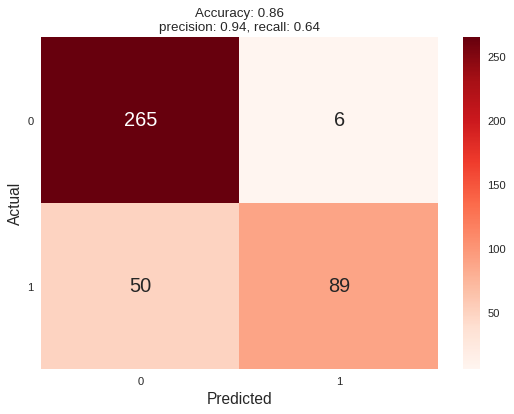

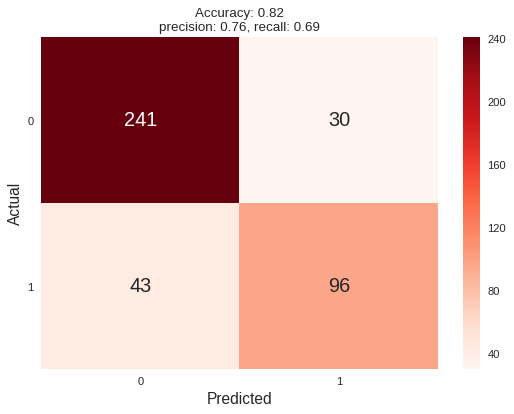

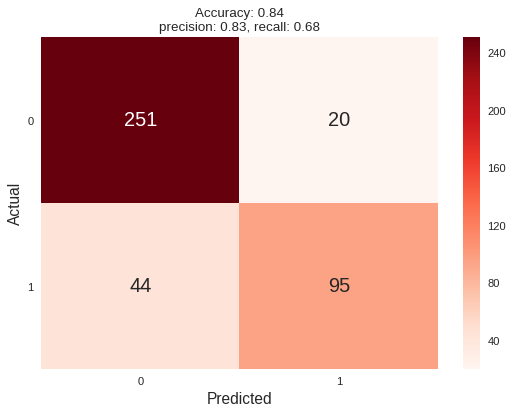

In [13]:
logreg = linear_model.LogisticRegression(C=1,penalty='l2',class_weight='balanced')
logreg.fit(X_train_features.values, y_train.values)
Zlogreg = logreg.predict(X_test_features.values)
preds['prediction']=Zlogreg
print(cross_val_score(logreg, X_train_features.values, y_train.values))
plot_confusion_matrix2(preds['actual'],preds['prediction'],labels=None)
print(classification_report(preds['actual'],preds['prediction']))

rf= RandomForestClassifier(n_estimators=10,class_weight='balanced',max_features='log2',random_state=24)
rf.fit(X_train_features.values, y_train.values)
Zrf = rf.predict(X_test_features.values)
preds['prediction']=Zrf
print(cross_val_score(rf, X_train_features.values, y_train.values))
plot_confusion_matrix2(preds['actual'],preds['prediction'],labels=None)
print(classification_report(preds['actual'],preds['prediction']))

est=LinearSVC(class_weight='balanced')
est.fit(X_train_features.values, y_train.values)
Zest = est.predict(X_test_features.values)
preds['prediction']=Zest
print(cross_val_score(est, X_train_features.values, y_train.values))
plot_confusion_matrix2(preds['actual'],preds['prediction'],labels=None)
print(classification_report(preds['actual'],preds['prediction']))

plt.show()

In [14]:
gr = sum(((train['final_disposition']=='Granted in full')))
dn =  sum(((train['final_disposition']=='Denied in full')))

print dn, gr, dn+gr, float(gr)/(dn+gr)

gr = sum(((test['final_disposition']=='Granted in full')))
dn = sum(((test['final_disposition']=='Denied in full')))

print dn, gr, dn+gr, float(gr)/(dn+gr)

gr = sum(((cdata['final_disposition']=='Granted in full')))
dn = sum(((cdata['final_disposition']=='Denied in full')))

print dn, gr, dn+gr, float(gr)/(dn+gr)



809 418 1227 0.340668296659
271 139 410 0.339024390244
1080 557 1637 0.340256566891


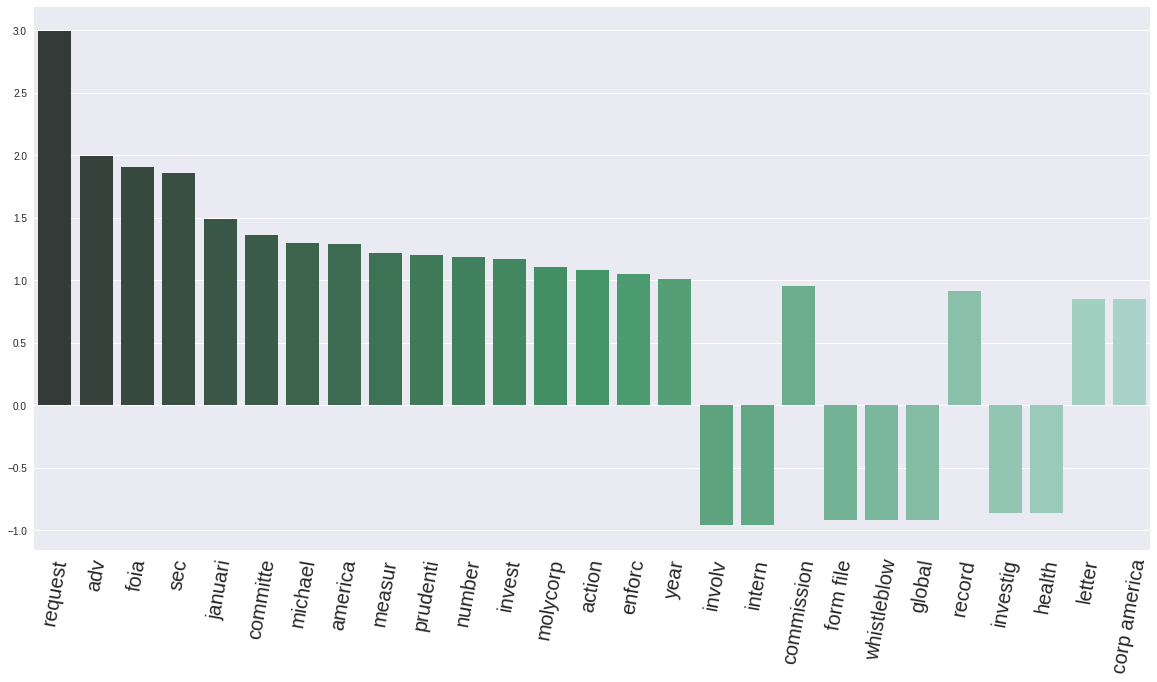

In [15]:
mylist=np.absolute(logreg.coef_).tolist()[0]
ins=sorted(range(len(mylist)),key=lambda x:mylist[x],reverse=True)
fis=X_train_features.columns.values[ins]
fins=logreg.coef_[0][ins]

plt.figure()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=80,size=20)
sns.barplot(x=fis[:27],y=fins[:27],palette="BuGn_d",ax=ax,orient="v")
plt.show()

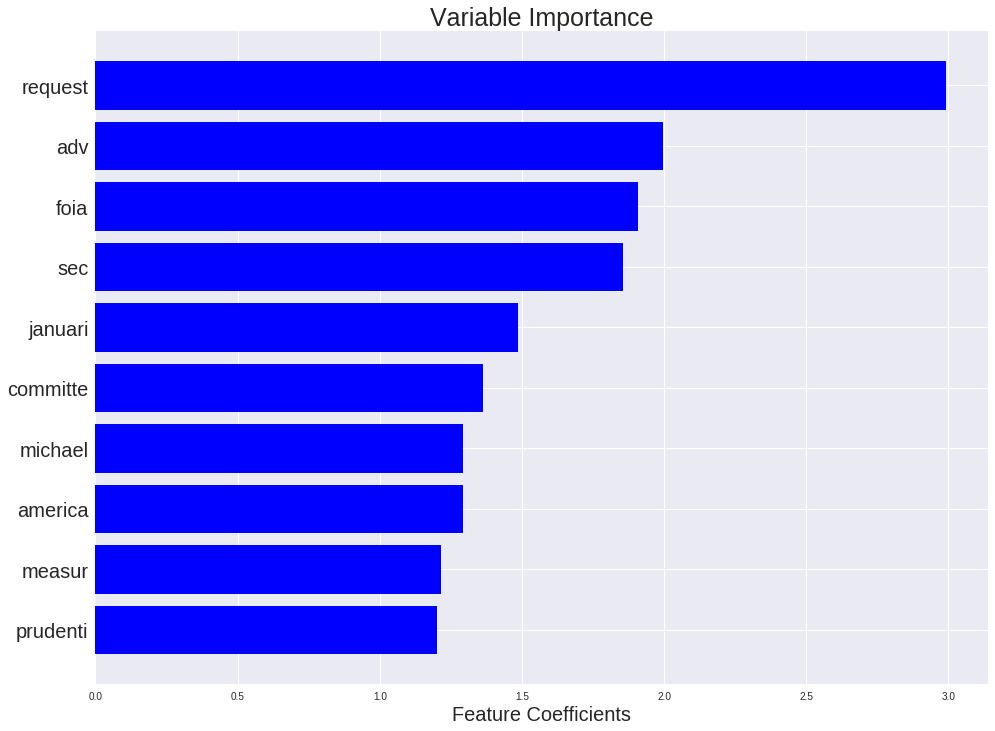

In [16]:
feature_importance = logreg.coef_[0]

top =0
    
dep=10

sorted_idx = np.argsort((feature_importance))

pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(1,figsize=(16, 12))

dep = len(pos)-dep

top = len(pos)-top

plt.barh(pos[dep:top], feature_importance[sorted_idx][dep:top], align='center', color='b')

plt.yticks(pos[dep:top], np.asanyarray(X_train_features.columns.values.tolist())[sorted_idx][dep:top], fontsize=20)

plt.xlabel('Feature Coefficients', fontsize=20)

plt.title('Variable Importance', fontsize=25)

plt.show()

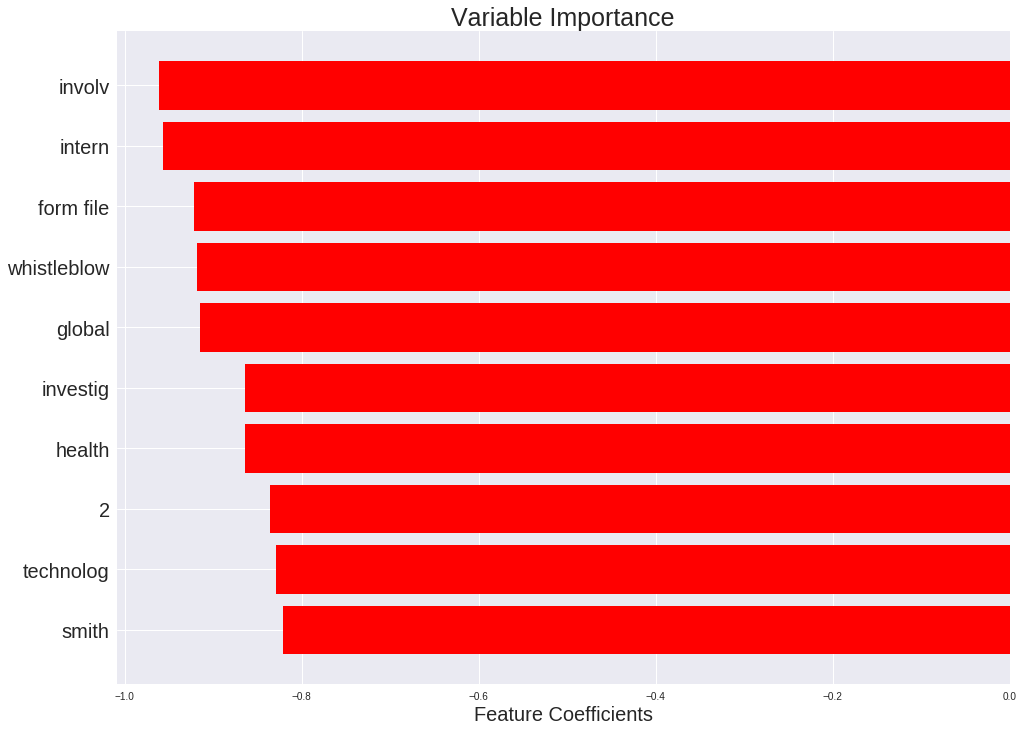

In [17]:
feature_importance = logreg.coef_[0]

top =0
    
dep=10

sorted_idx = np.argsort(-feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(16, 12))

dep = len(pos)-dep

top = len(pos)-top

plt.barh(pos[dep:top], feature_importance[sorted_idx][dep:top], align='center', color='r')

plt.yticks(pos[dep:top], np.asanyarray(X_train_features.columns.values.tolist())[sorted_idx][dep:top], fontsize=20)

plt.xlabel('Feature Coefficients', fontsize=20)

plt.title('Variable Importance', fontsize=25)

plt.show()

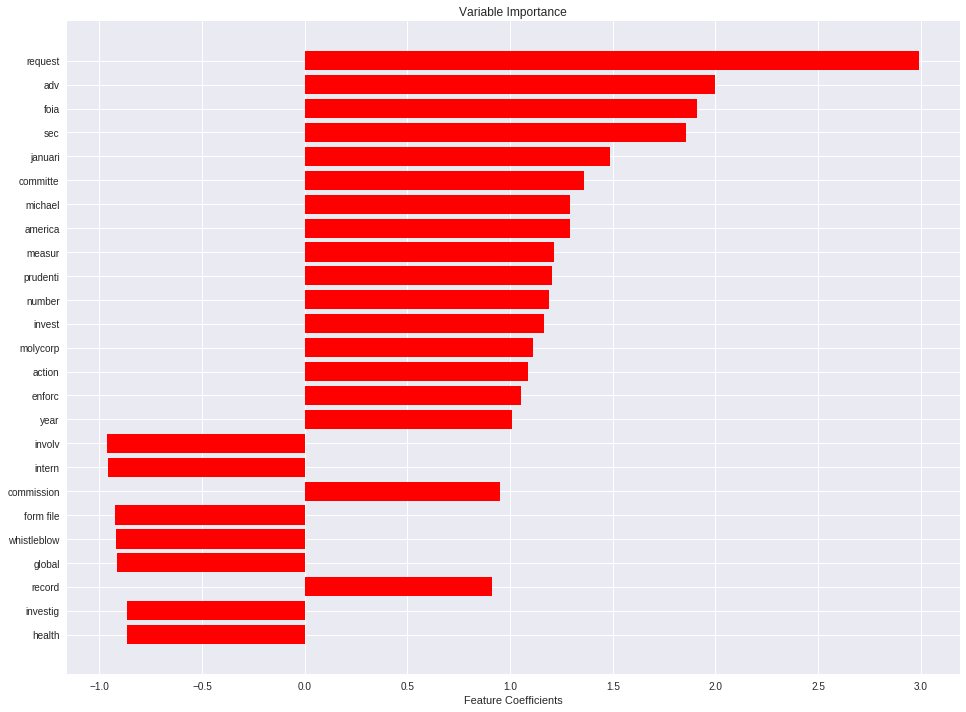

In [18]:
feature_importance = logreg.coef_[0]

top =0
    
dep=25

sorted_idx = np.argsort(np.absolute(feature_importance))

pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(16, 12))

dep = len(pos)-dep

top = len(pos)-top

plt.barh(pos[dep:top], feature_importance[sorted_idx][dep:top], align='center', color='r')

plt.yticks(pos[dep:top], np.asanyarray(X_train_features.columns.values.tolist())[sorted_idx][dep:top])

plt.xlabel('Feature Coefficients')

plt.title('Variable Importance')

plt.show()

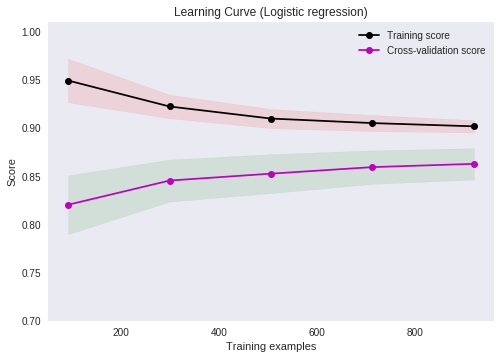

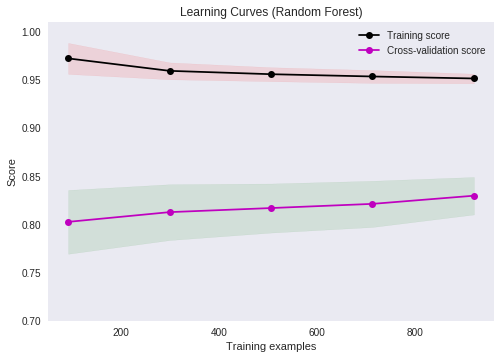

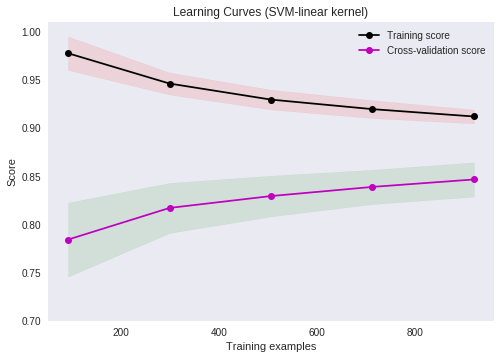

In [19]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
    title : string
        Title for the chart.
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.
        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="k",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="m",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y =X_train_features.values, y_train.values
cv = ShuffleSplit(n_splits=100, test_size=0.25, random_state=0)

title = "Learning Curve (Logistic regression)"
plot_learning_curve(logreg, title, X, y, ylim=(0.7, 1.01), cv=cv,n_jobs=4)

title = "Learning Curves (Random Forest)"
plot_learning_curve(rf, title, X, y, ylim=(0.7, 1.01),cv=cv, n_jobs=4)

title = "Learning Curves (SVM-linear kernel)"
plot_learning_curve(est, title, X, y, ylim=(0.7, 1.01),cv=cv, n_jobs=4)

plt.show()


In [20]:
import pickle
pickle.dump(logreg,open("logregmodel.p","wb"))

In [21]:
n_col=X_train_features.shape[1]
newdata=np.zeros(n_col)
newdf=pd.DataFrame([newdata])

In [22]:
old_col_names=X_train_features.columns
newdf.columns=old_col_names
newdf.to_csv("old_df.csv",index=False)

In [24]:
model = pickle.load(open("logregmodel.p", "rb"))

In [25]:
result = model.predict_proba(newdf)

In [26]:
print result

[[ 0.67179895  0.32820105]]
